In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
import joblib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from hyperopt import hp, Trials, tpe
from HPOpt import HPOpt

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data1 = pd.read_csv('data/listings_1.csv')
data2 = pd.read_csv('data/listings_2.csv')
data3 = pd.read_csv('data/listings_3.csv')
data = pd.concat([data, data1,data2,data3])
#data = data.drop_duplicates(subset=data.columns.difference(['price']))
data = data.drop_duplicates()
data = data.reset_index()
data = data.drop(["index"],axis=1)

In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

This pattern has match groups. To actually get the groups, use str.extract.


,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
0,0.0,1,2,1,1,1,9823,3,1125,30,...,0,0,0,1,0,1,0,0,1,0
1,1.0,1,2,1,1,1,5687,2,730,24,...,0,0,0,1,0,1,0,0,1,0
2,0.0,1,2,1,1,1,3728,7,1125,98,...,0,0,0,1,0,1,0,0,1,0
3,1.0,1,4,2,1,1,6514,14,1125,10,...,0,0,0,1,0,1,0,0,1,0
4,1.0,0,2,1,1,1,3584,5,730,29,...,0,0,0,1,0,1,0,0,1,0


In [38]:
data_test=dataclean[["price","Agronomia"]]

In [42]:
data_test[data_test["Agronomia"]==1].describe()

,price,Agronomia
count,47.00000,47.00000
mean,4415.97872,1.00000
std,3567.07708,0.00000
min,1104.00000,1.00000
25%,2318.00000,1.00000
50%,3450.00000,1.00000
75%,4883.00000,1.00000
max,18094.00000,1.00000


In [4]:
dataclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 49826
Data columns (total 75 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       47883 non-null  float64
 1   host_identity_verified  47883 non-null  int32  
 2   accommodates            47883 non-null  int32  
 3   bathrooms               47883 non-null  int32  
 4   bedrooms                47883 non-null  int32  
 5   beds                    47883 non-null  int32  
 6   price                   47883 non-null  int64  
 7   minimum_nights          47883 non-null  int64  
 8   maximum_nights          47883 non-null  int32  
 9   number_of_reviews       47883 non-null  int64  
 10  review_scores_rating    47883 non-null  float32
 11  air_conditioning        47883 non-null  int32  
 12  pool                    47883 non-null  int32  
 13  parking                 47883 non-null  int32  
 14  tv                      47883 non-null

In [5]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

---
### Funciones extras

In [6]:
def getscores(model,X_test,y_test,X_train,y_train,model_name):
    y_pred_test = model.predict(X_test)
    
    mse_test = np.round(mean_squared_error(y_test, y_pred_test),5)
    rmse_test = np.round(np.sqrt(mse_test),5)
    mae_test = np.round(mean_absolute_error(y_test, y_pred_test),5)
    r2_test =  np.round(r2_score(y_test, y_pred_test),5)
    
    y_pred_train = model.predict(X_train)

    mse_train = np.round(mean_squared_error(y_train, y_pred_train),5)
    rmse_train = np.round(np.sqrt(mse_train),5)
    mae_train = np.round(mean_absolute_error(y_train, y_pred_train),5)
    r2_train =  np.round(r2_score(y_train, y_pred_train),5)
    
    data = [mse_test,rmse_test,mae_test,r2_test, mse_train,rmse_train,mae_train,r2_train]
    
    return {model_name:data}
    
def plot_train_test(y_test, y_pred_test, y_train, y_pred_train, model_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
    axes[0].plot([i for i in range(len(y_test))],y_pred_test, 'bo', label="Predicted "+model_name+" values")
    axes[0].legend()

    axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
    axes[1].plot([i for i in range(len(y_train))],y_pred_train, 'bo', label="Predicted "+model_name+" values")
    axes[1].legend()

    fig.text(0.5, 0.09, 'Item', ha='center')
    fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
    plt.show()

---
## Algoritmos
### Árboles

In [7]:
# Random Forest
rndfo_reg_params = {
    'bootstrap':         hp.choice('bootstrap', ["True", "False"]),
    'max_depth':         hp.choice("max_depth", np.arange(1, 11, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['auto', 'sqrt','log2']),
    'min_samples_leaf':  hp.choice('min_samples_leaf', [0.1,1,2,4]),
    'min_samples_split': hp.choice('min_samples_split', [0.1,0.5,0.8,0.9,2,4,6]),
    'n_estimators':      hp.randint('n_estimators', 100, 1000),
    'random_state' : 50,
    'verbose': False,
    'n_jobs' :-1,
}

rndfo_para = dict()
rndfo_para['reg_params'] = rndfo_reg_params
rndfo_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
    'eval_metric': 'rmse',
}
xgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
}

lgb_fit_params = {
    'eval_metric':      'l2',
    'early_stopping_rounds': 10,
    'verbose': False,
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# CatBoost parameters
ctb_reg_params = {
    'random_state':   50,
    'learning_rate':  hp.uniform('learning_rate', 0.1, 0.5),
    'iterations':     hp.randint('iterations',100,1000),
    'l2_leaf_reg':    hp.randint('l2_leaf_reg',1,10),
    'depth':          hp.randint('depth',1,10),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli']),
    'eval_metric':    'RMSE',
}

ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False,
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [8]:
obj = HPOpt(X_train, X_test, y_train, y_test)

trials = [Trials(),Trials(),Trials(),Trials()]

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials[0], algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials[1], algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=trials[2], algo=tpe.suggest, max_evals=100)
rndfor_opt = obj.process(fn_name='rndfor_reg', space=rndfo_para, trials=trials[3], algo=tpe.suggest, max_evals=100)

  1%|▍                                               | 1/100 [00:01<02:11,  1.33s/trial, best loss: 3388.2609367189607]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  2%|▉                                               | 2/100 [00:02<02:05,  1.28s/trial, best loss: 3388.2609367189607]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  3%|█▍                                               | 3/100 [00:17<12:25,  7.68s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  4%|█▉                                               | 4/100 [00:21<09:54,  6.20s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  5%|██▍                                              | 5/100 [00:22<06:39,  4.21s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  6%|██▉                                              | 6/100 [00:22<04:31,  2.88s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  7%|███▍                                             | 7/100 [00:23<03:32,  2.28s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  8%|███▉                                             | 8/100 [00:25<03:00,  1.96s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  9%|████▍                                            | 9/100 [00:27<03:13,  2.12s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 10%|████▊                                           | 10/100 [00:29<03:01,  2.02s/trial, best loss: 3298.124024727494]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 11%|█████▎                                          | 11/100 [00:36<05:12,  3.51s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 12%|█████▊                                          | 12/100 [00:37<04:03,  2.77s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 13%|██████▏                                         | 13/100 [00:40<04:16,  2.95s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 14%|██████▋                                         | 14/100 [00:41<03:27,  2.41s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 15%|███████▏                                        | 15/100 [00:49<05:45,  4.07s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 16%|███████▋                                        | 16/100 [00:51<04:34,  3.26s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 17%|████████▏                                       | 17/100 [00:56<05:13,  3.78s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 18%|████████▋                                       | 18/100 [01:04<07:09,  5.23s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 19%|█████████                                       | 19/100 [01:05<05:18,  3.94s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 20%|█████████▌                                      | 20/100 [01:05<03:47,  2.84s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 21%|██████████                                      | 21/100 [01:06<02:46,  2.11s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 22%|██████████▌                                     | 22/100 [01:19<06:53,  5.30s/trial, best loss: 3215.742787753801]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 23%|██████████▊                                    | 23/100 [01:31<09:31,  7.42s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 24%|███████████▎                                   | 24/100 [01:39<09:33,  7.55s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 25%|███████████▊                                   | 25/100 [01:46<09:08,  7.31s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 26%|████████████▏                                  | 26/100 [01:54<09:30,  7.71s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 27%|████████████▋                                  | 27/100 [01:59<08:28,  6.97s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 28%|█████████████▏                                 | 28/100 [02:07<08:40,  7.23s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 29%|█████████████▋                                 | 29/100 [02:14<08:19,  7.03s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 30%|██████████████                                 | 30/100 [02:15<06:04,  5.21s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 31%|██████████████▌                                | 31/100 [02:21<06:28,  5.63s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 32%|███████████████                                | 32/100 [02:24<05:22,  4.74s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 33%|███████████████▌                               | 33/100 [02:26<04:17,  3.84s/trial, best loss: 2918.3840363864165]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 34%|████████████████▎                               | 34/100 [02:38<06:55,  6.29s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 35%|████████████████▊                               | 35/100 [02:39<05:08,  4.75s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 36%|█████████████████▎                              | 36/100 [02:40<03:50,  3.60s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 37%|█████████████████▊                              | 37/100 [02:47<04:55,  4.69s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 38%|██████████████████▏                             | 38/100 [02:49<04:06,  3.97s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 39%|██████████████████▋                             | 39/100 [02:51<03:21,  3.31s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 40%|███████████████████▏                            | 40/100 [02:55<03:32,  3.54s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 41%|███████████████████▋                            | 41/100 [02:56<02:41,  2.73s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 42%|████████████████████▏                           | 42/100 [02:58<02:15,  2.33s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 43%|████████████████████▋                           | 43/100 [02:59<01:54,  2.02s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 44%|█████████████████████                           | 44/100 [03:04<02:53,  3.10s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 45%|█████████████████████▌                          | 45/100 [03:05<02:05,  2.28s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 46%|██████████████████████                          | 46/100 [03:14<03:54,  4.34s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 47%|██████████████████████▌                         | 47/100 [03:15<03:00,  3.41s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 48%|███████████████████████                         | 48/100 [03:19<03:00,  3.47s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 49%|███████████████████████▌                        | 49/100 [03:23<03:11,  3.75s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 50%|████████████████████████                        | 50/100 [03:29<03:39,  4.39s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 51%|████████████████████████▍                       | 51/100 [03:34<03:45,  4.60s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 52%|████████████████████████▉                       | 52/100 [03:35<02:44,  3.42s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 53%|█████████████████████████▍                      | 53/100 [03:37<02:17,  2.93s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 54%|█████████████████████████▉                      | 54/100 [03:37<01:45,  2.29s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 55%|██████████████████████████▍                     | 55/100 [03:40<01:47,  2.38s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 56%|██████████████████████████▉                     | 56/100 [03:44<02:00,  2.73s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 57%|███████████████████████████▎                    | 57/100 [03:46<01:55,  2.69s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 58%|███████████████████████████▊                    | 58/100 [03:52<02:33,  3.66s/trial, best loss: 2905.363468194882]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 59%|███████████████████████████▋                   | 59/100 [04:07<04:50,  7.08s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 60%|████████████████████████████▏                  | 60/100 [04:18<05:24,  8.10s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 61%|████████████████████████████▋                  | 61/100 [04:29<05:54,  9.08s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 62%|█████████████████████████████▏                 | 62/100 [04:38<05:39,  8.92s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 63%|█████████████████████████████▌                 | 63/100 [04:55<07:03, 11.44s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 64%|██████████████████████████████                 | 64/100 [05:05<06:37, 11.05s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 65%|██████████████████████████████▌                | 65/100 [05:07<04:47,  8.22s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 66%|███████████████████████████████                | 66/100 [05:14<04:35,  8.12s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 67%|███████████████████████████████▍               | 67/100 [05:21<04:07,  7.49s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 68%|███████████████████████████████▉               | 68/100 [05:21<02:56,  5.50s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 69%|████████████████████████████████▍              | 69/100 [05:34<03:59,  7.73s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 70%|████████████████████████████████▉              | 70/100 [05:41<03:41,  7.39s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 71%|█████████████████████████████████▎             | 71/100 [05:43<02:45,  5.72s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 72%|█████████████████████████████████▊             | 72/100 [05:45<02:08,  4.58s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 73%|██████████████████████████████████▎            | 73/100 [05:50<02:13,  4.95s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 74%|██████████████████████████████████▊            | 74/100 [05:52<01:42,  3.94s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 75%|███████████████████████████████████▎           | 75/100 [06:01<02:15,  5.40s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 76%|███████████████████████████████████▋           | 76/100 [06:08<02:22,  5.96s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 77%|████████████████████████████████████▏          | 77/100 [06:09<01:40,  4.36s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 78%|████████████████████████████████████▋          | 78/100 [06:16<01:56,  5.29s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 79%|█████████████████████████████████████▏         | 79/100 [06:35<03:16,  9.35s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 80%|█████████████████████████████████████▌         | 80/100 [06:45<03:08,  9.44s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 81%|██████████████████████████████████████         | 81/100 [06:48<02:21,  7.46s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 82%|██████████████████████████████████████▌        | 82/100 [06:49<01:43,  5.75s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 83%|███████████████████████████████████████        | 83/100 [06:54<01:33,  5.48s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 84%|███████████████████████████████████████▍       | 84/100 [06:55<01:06,  4.16s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 85%|███████████████████████████████████████▉       | 85/100 [06:59<01:01,  4.11s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 86%|████████████████████████████████████████▍      | 86/100 [07:02<00:52,  3.72s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 87%|████████████████████████████████████████▉      | 87/100 [07:06<00:47,  3.69s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 88%|█████████████████████████████████████████▎     | 88/100 [07:06<00:32,  2.69s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 89%|█████████████████████████████████████████▊     | 89/100 [07:11<00:38,  3.46s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 90%|██████████████████████████████████████████▎    | 90/100 [07:17<00:41,  4.14s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 91%|██████████████████████████████████████████▊    | 91/100 [07:26<00:49,  5.53s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 92%|███████████████████████████████████████████▏   | 92/100 [07:30<00:40,  5.12s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 93%|███████████████████████████████████████████▋   | 93/100 [07:31<00:28,  4.04s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 94%|████████████████████████████████████████████▏  | 94/100 [07:49<00:49,  8.21s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 95%|████████████████████████████████████████████▋  | 95/100 [07:54<00:36,  7.25s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 96%|█████████████████████████████████████████████  | 96/100 [08:00<00:27,  6.87s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 97%|█████████████████████████████████████████████▌ | 97/100 [08:07<00:20,  6.77s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 98%|██████████████████████████████████████████████ | 98/100 [08:07<00:09,  4.88s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 99%|██████████████████████████████████████████████▌| 99/100 [08:15<00:05,  5.63s/trial, best loss: 2871.5312350047557]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



100%|███████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/trial, best loss: 3320.820313058444]


In [9]:
# Entreno los modelos de árboles en base a sus parámetros
xgb_model=xgb.XGBRegressor(**trials[0].results[np.argmin([result['loss'] for result in trials[0].results])]['params'])
xgb_model.fit(X_train,y_train)

lgb_model = lgb.LGBMRegressor(**trials[1].results[np.argmin([result['loss'] for result in trials[1].results])]['params'])
lgb_model.fit(X_train,y_train)

ctb_model = ctb.CatBoostRegressor(**trials[2].results[np.argmin([result['loss'] for result in trials[2].results])]['params'])
ctb_model.fit(X_train,y_train)

rndfo_model = RandomForestRegressor(**trials[3].results[np.argmin([result['loss'] for result in trials[3].results])]['params'])
rndfo_model.fit(X_train,y_train)

0:	learn: 4407.3249190	total: 12.3ms	remaining: 10.7s
1:	learn: 4204.1482917	total: 25.7ms	remaining: 11.2s
2:	learn: 4057.3558149	total: 44.7ms	remaining: 13s
3:	learn: 3944.2830054	total: 103ms	remaining: 22.4s
4:	learn: 3851.7051169	total: 117ms	remaining: 20.4s
5:	learn: 3777.5089175	total: 128ms	remaining: 18.6s
6:	learn: 3716.7201080	total: 140ms	remaining: 17.3s
7:	learn: 3667.6535478	total: 152ms	remaining: 16.5s
8:	learn: 3633.7096834	total: 163ms	remaining: 15.8s
9:	learn: 3601.1532316	total: 175ms	remaining: 15.2s
10:	learn: 3570.3442054	total: 185ms	remaining: 14.6s
11:	learn: 3546.1372722	total: 230ms	remaining: 16.6s
12:	learn: 3524.1938478	total: 242ms	remaining: 16.1s
13:	learn: 3501.3916196	total: 259ms	remaining: 16s
14:	learn: 3487.6015581	total: 270ms	remaining: 15.5s
15:	learn: 3469.1010077	total: 281ms	remaining: 15.1s
16:	learn: 3454.6753400	total: 305ms	remaining: 15.4s
17:	learn: 3443.8228775	total: 318ms	remaining: 15.2s
18:	learn: 3418.9080024	total: 330ms	re

165:	learn: 2798.0243399	total: 2.67s	remaining: 11.4s
166:	learn: 2794.6900003	total: 2.68s	remaining: 11.4s
167:	learn: 2792.5737396	total: 2.7s	remaining: 11.4s
168:	learn: 2788.2839232	total: 2.73s	remaining: 11.4s
169:	learn: 2787.6713713	total: 2.74s	remaining: 11.4s
170:	learn: 2782.9639900	total: 2.76s	remaining: 11.4s
171:	learn: 2781.1650435	total: 2.79s	remaining: 11.4s
172:	learn: 2779.4561232	total: 2.8s	remaining: 11.4s
173:	learn: 2776.4477414	total: 2.86s	remaining: 11.5s
174:	learn: 2773.6685588	total: 2.87s	remaining: 11.5s
175:	learn: 2771.5881111	total: 2.89s	remaining: 11.5s
176:	learn: 2768.4734293	total: 2.9s	remaining: 11.5s
177:	learn: 2766.4516960	total: 2.91s	remaining: 11.4s
178:	learn: 2763.6912493	total: 2.92s	remaining: 11.4s
179:	learn: 2760.7550364	total: 2.94s	remaining: 11.4s
180:	learn: 2757.7431790	total: 2.96s	remaining: 11.4s
181:	learn: 2752.9310771	total: 2.97s	remaining: 11.4s
182:	learn: 2749.4161294	total: 3.01s	remaining: 11.4s
183:	learn: 2

319:	learn: 2433.1403559	total: 5.06s	remaining: 8.8s
320:	learn: 2431.3776175	total: 5.07s	remaining: 8.78s
321:	learn: 2430.2033093	total: 5.08s	remaining: 8.76s
322:	learn: 2428.8648669	total: 5.1s	remaining: 8.76s
323:	learn: 2427.0630176	total: 5.13s	remaining: 8.76s
324:	learn: 2424.9257698	total: 5.15s	remaining: 8.75s
325:	learn: 2423.6149928	total: 5.17s	remaining: 8.73s
326:	learn: 2420.3159147	total: 5.18s	remaining: 8.71s
327:	learn: 2418.7781489	total: 5.19s	remaining: 8.69s
328:	learn: 2417.1007036	total: 5.2s	remaining: 8.66s
329:	learn: 2415.6771307	total: 5.21s	remaining: 8.64s
330:	learn: 2414.4160915	total: 5.23s	remaining: 8.62s
331:	learn: 2413.8510322	total: 5.24s	remaining: 8.6s
332:	learn: 2412.5734843	total: 5.26s	remaining: 8.59s
333:	learn: 2411.2961660	total: 5.27s	remaining: 8.56s
334:	learn: 2408.6466516	total: 5.28s	remaining: 8.54s
335:	learn: 2406.0429126	total: 5.29s	remaining: 8.52s
336:	learn: 2403.2527996	total: 5.32s	remaining: 8.52s
337:	learn: 24

479:	learn: 2177.7730222	total: 7.46s	remaining: 6.17s
480:	learn: 2176.8088767	total: 7.47s	remaining: 6.15s
481:	learn: 2175.8457610	total: 7.5s	remaining: 6.14s
482:	learn: 2175.2362795	total: 7.53s	remaining: 6.14s
483:	learn: 2174.6882712	total: 7.54s	remaining: 6.13s
484:	learn: 2173.1122658	total: 7.56s	remaining: 6.11s
485:	learn: 2170.2845210	total: 7.57s	remaining: 6.09s
486:	learn: 2168.6068512	total: 7.58s	remaining: 6.07s
487:	learn: 2167.0995493	total: 7.59s	remaining: 6.05s
488:	learn: 2165.4863244	total: 7.61s	remaining: 6.03s
489:	learn: 2165.1086428	total: 7.62s	remaining: 6.01s
490:	learn: 2163.5343372	total: 7.65s	remaining: 6.01s
491:	learn: 2161.0958879	total: 7.66s	remaining: 6s
492:	learn: 2160.5163143	total: 7.68s	remaining: 5.98s
493:	learn: 2158.6649962	total: 7.7s	remaining: 5.97s
494:	learn: 2157.6170183	total: 7.71s	remaining: 5.95s
495:	learn: 2156.9132469	total: 7.72s	remaining: 5.93s
496:	learn: 2155.6721467	total: 7.73s	remaining: 5.91s
497:	learn: 215

639:	learn: 1989.5291740	total: 9.86s	remaining: 3.65s
640:	learn: 1987.7927928	total: 9.87s	remaining: 3.63s
641:	learn: 1986.6615663	total: 9.89s	remaining: 3.62s
642:	learn: 1986.0834842	total: 9.9s	remaining: 3.6s
643:	learn: 1985.0576745	total: 9.91s	remaining: 3.58s
644:	learn: 1983.0525114	total: 9.93s	remaining: 3.57s
645:	learn: 1981.8187924	total: 9.95s	remaining: 3.56s
646:	learn: 1980.3696789	total: 9.96s	remaining: 3.54s
647:	learn: 1979.8327319	total: 9.97s	remaining: 3.52s
648:	learn: 1979.2244906	total: 9.98s	remaining: 3.51s
649:	learn: 1978.5588700	total: 9.99s	remaining: 3.49s
650:	learn: 1977.4051611	total: 10s	remaining: 3.47s
651:	learn: 1976.3300982	total: 10s	remaining: 3.46s
652:	learn: 1975.3718615	total: 10s	remaining: 3.44s
653:	learn: 1973.3303648	total: 10.1s	remaining: 3.43s
654:	learn: 1972.5870285	total: 10.1s	remaining: 3.42s
655:	learn: 1971.1412636	total: 10.1s	remaining: 3.4s
656:	learn: 1970.8085736	total: 10.1s	remaining: 3.39s
657:	learn: 1968.83

790:	learn: 1860.7642529	total: 12.1s	remaining: 1.32s
791:	learn: 1859.5781416	total: 12.2s	remaining: 1.3s
792:	learn: 1859.0040776	total: 12.2s	remaining: 1.29s
793:	learn: 1857.2429450	total: 12.2s	remaining: 1.28s
794:	learn: 1856.6829661	total: 12.2s	remaining: 1.26s
795:	learn: 1856.0350516	total: 12.2s	remaining: 1.25s
796:	learn: 1855.5604700	total: 12.3s	remaining: 1.23s
797:	learn: 1854.8951515	total: 12.3s	remaining: 1.22s
798:	learn: 1854.3428520	total: 12.3s	remaining: 1.2s
799:	learn: 1853.7476848	total: 12.3s	remaining: 1.18s
800:	learn: 1853.3306612	total: 12.3s	remaining: 1.17s
801:	learn: 1852.8736897	total: 12.3s	remaining: 1.15s
802:	learn: 1851.5884664	total: 12.3s	remaining: 1.14s
803:	learn: 1851.0254390	total: 12.4s	remaining: 1.12s
804:	learn: 1850.5224579	total: 12.4s	remaining: 1.11s
805:	learn: 1849.7463208	total: 12.4s	remaining: 1.09s
806:	learn: 1849.4587920	total: 12.4s	remaining: 1.07s
807:	learn: 1848.8440883	total: 12.4s	remaining: 1.06s
808:	learn: 

RandomForestRegressor(bootstrap='False', max_depth=10, n_estimators=955,
                      n_jobs=-1, random_state=50, verbose=False)

### Visualización previa de los alfas

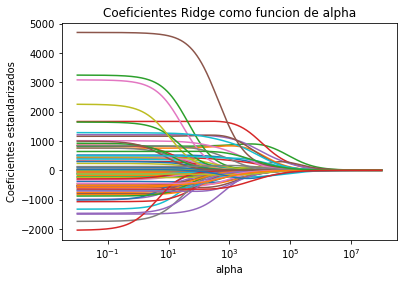

In [10]:
#Análisis previo de los alpha
alphas_ridge = np.logspace(-2, 8,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

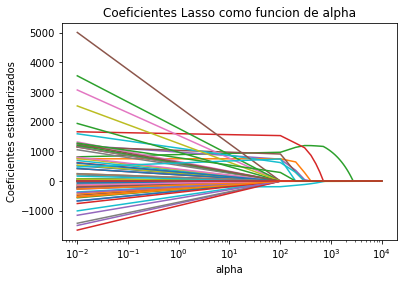

In [11]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,10000,100)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

### GridSearch para otros algoritmos de regresión

In [12]:
#Inicializo pipelines de regresión
pipe_linr = Pipeline([('scl', None),
                    ('linr', linear_model.LinearRegression())])
pipe_ridge = Pipeline([('scl', None),
                    ('ridge', linear_model.Ridge(random_state=50))])
pipe_lasso = Pipeline([('scl', None),
                    ('lasso',linear_model.Lasso(random_state=50))])

# Parámetros para diversos pipelines
linr_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    }]

ridge_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'ridge__alpha': np.logspace(-2, 8,400)
                    }]

lasso_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'lasso__alpha': np.linspace(0.01,10000,100),
                    'lasso__max_iter': [10000],
                    }]

linr_grid_search = GridSearchCV(estimator=pipe_linr,
                        param_grid = linr_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

ridge_grid_search = GridSearchCV(estimator=pipe_ridge,
                        param_grid = ridge_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

lasso_grid_search = GridSearchCV(estimator=pipe_lasso,
                        param_grid = lasso_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')


grids = [linr_grid_search, ridge_grid_search, lasso_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.5s finished
The least populated class in y has only 1 members, which is less than n_splits=5.


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.0min finished


---
## Análisis

In [13]:
models = [
        {
        'name':'Linear Regression',
        'model': grids[0].best_estimator_
        },
        {
        'name':'Ridge',
        'model': grids[1].best_estimator_
        },
        {
        'name':'Lasso',
        'model': grids[2].best_estimator_
        },
        {
        'name':'XGBoost',
        'model': xgb_model
        },
        {
        'name':'LGBoost',
        'model': lgb_model
        },
        {
        'name':'CatBoost',
        'model': ctb_model
        },
        {
        'name':'Random Forest',
        'model': rndfo_model
        },
    ]

list=[]

for key in models:
    list.append(pd.DataFrame(getscores(key["model"],X_test,y_test,X_train,y_train,key["name"]),index=['MSE Test','RMSE Test','MAE Test','R2 Test','MSE Train','RMSE Train','MAE Train','R2 Train']))
    
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.concat(list,axis=1)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Linear Regression,Ridge,Lasso,XGBoost,LGBoost,CatBoost,Random Forest
MSE Test,13749254.03202,13754825.92317,13749176.02268,8186688.18370,9224086.25871,8181912.11567,11027847.55162
RMSE Test,3707.99866,3708.74991,3707.98814,2861.23892,3037.11808,2860.40419,3320.82031
MAE Test,2437.75692,2437.57650,2437.71455,1831.24782,1998.91113,1854.85696,2182.63204
R2 Test,0.36220,0.36194,0.36221,0.62024,0.57212,0.62046,0.48844
MSE Train,13507976.71047,13511688.64399,13507982.38045,2287002.03319,4439904.98484,3247080.39247,9257983.25378
RMSE Train,3675.31995,3675.82489,3675.32072,1512.28371,2107.10820,1801.96570,3042.69342
MAE Train,2448.14141,2447.20140,2448.09466,977.01272,1401.61912,1214.40471,2055.16938
R2 Train,0.37430,0.37413,0.37430,0.89407,0.79434,0.84959,0.57117


#### Gráficos LR

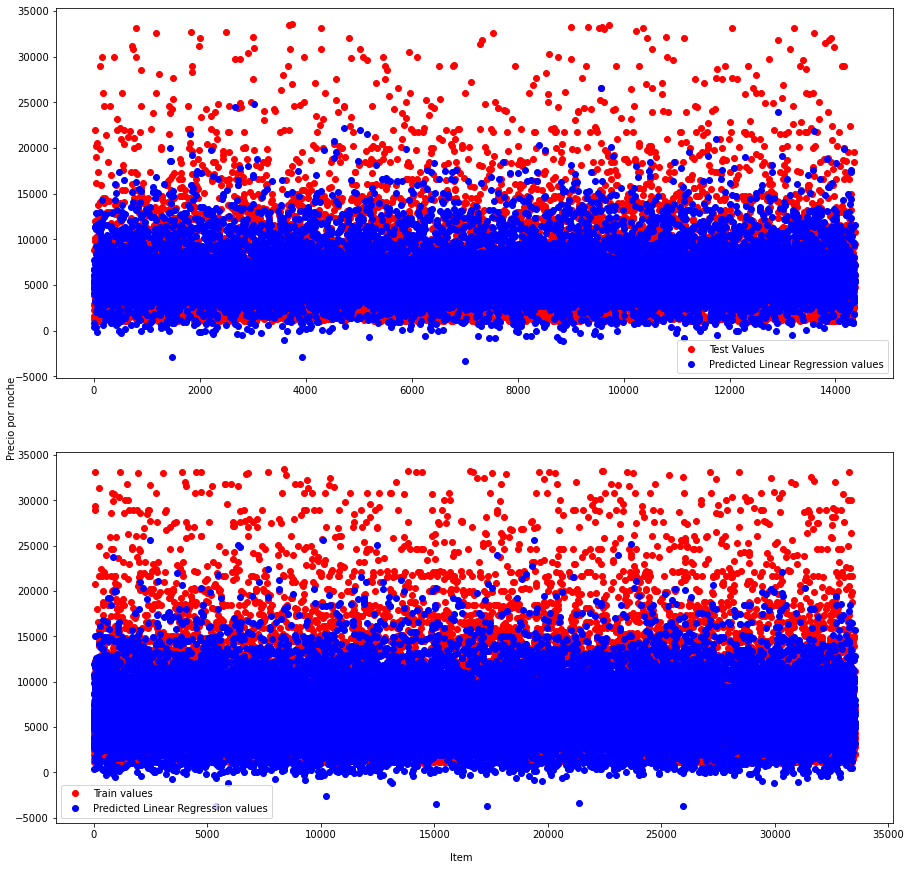

In [14]:
#Linear Regression
y_test_prediction = models[0]["model"].predict(X_test)
y_train_prediction = models[0]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[0]["name"])

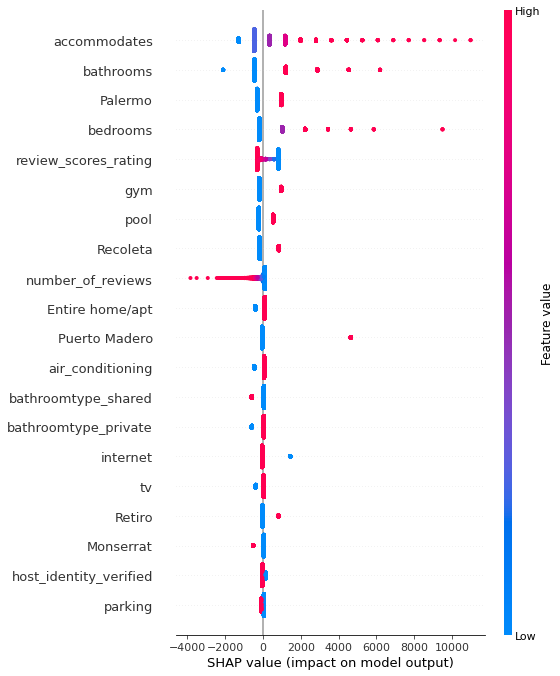

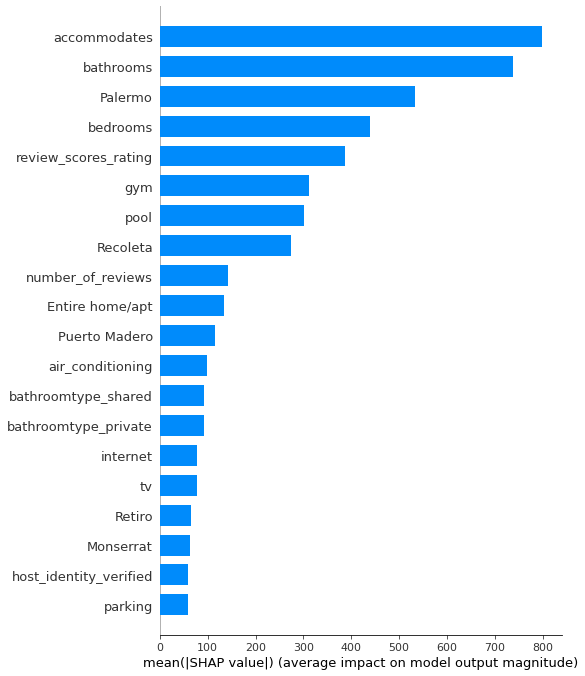

In [15]:
explainer = shap.LinearExplainer(linear_model.LinearRegression().fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Ridge

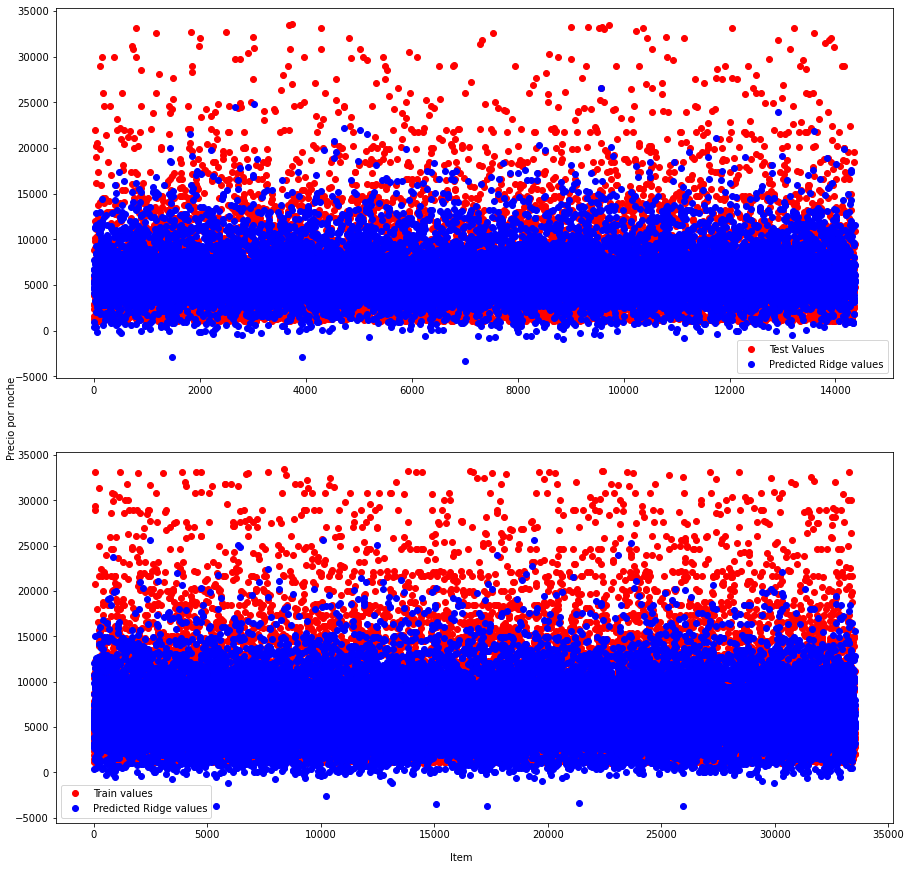

In [16]:
#Ridge
y_test_prediction = models[1]["model"].predict(X_test)
y_train_prediction = models[1]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[1]["name"])

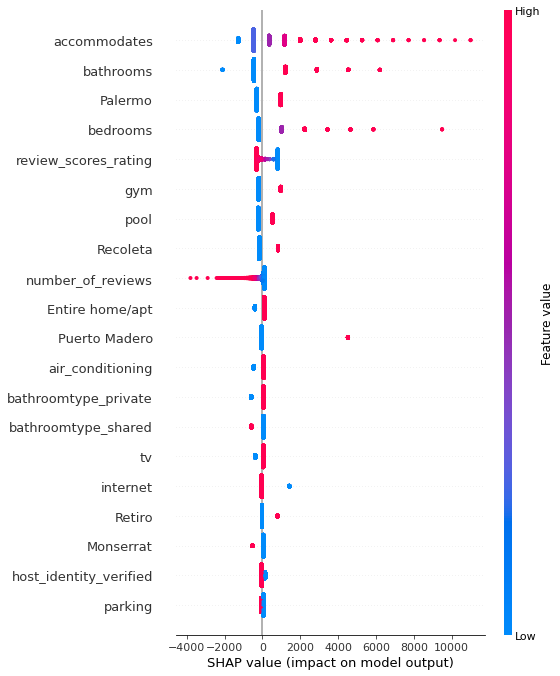

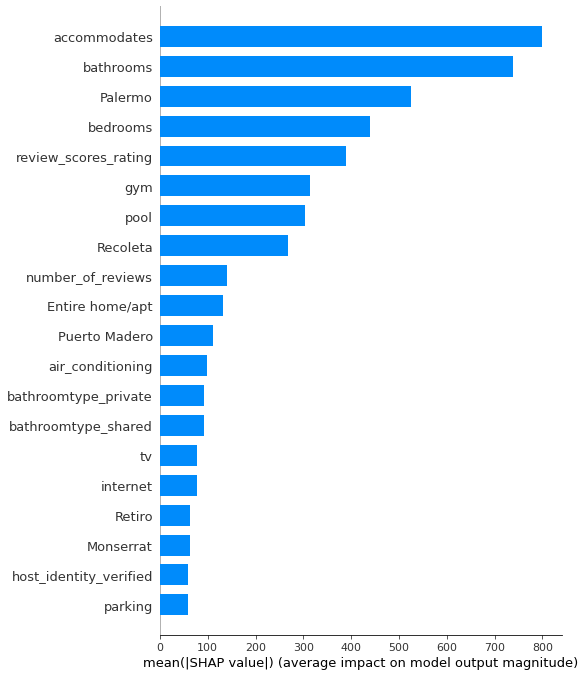

In [17]:
explainer = shap.LinearExplainer(linear_model.Ridge(alpha=models[1]["model"].steps[1][1].alpha,random_state=models[1]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Lasso

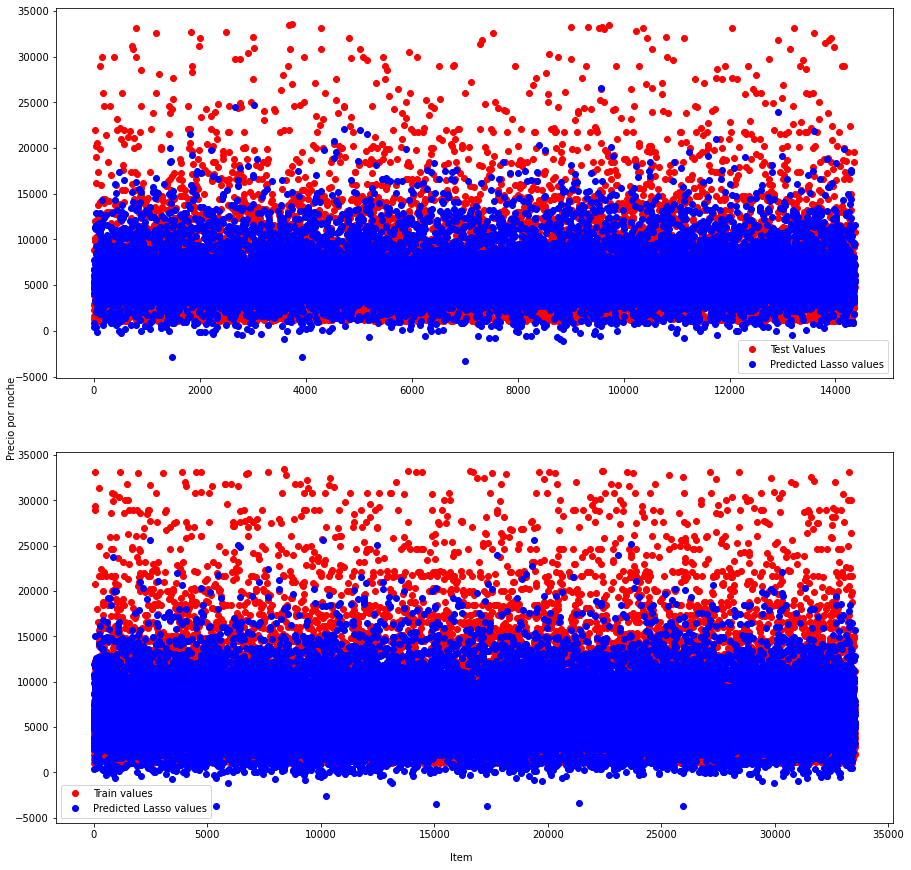

In [18]:
#Lasso
y_test_prediction = models[2]["model"].predict(X_test)
y_train_prediction = models[2]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[2]["name"])

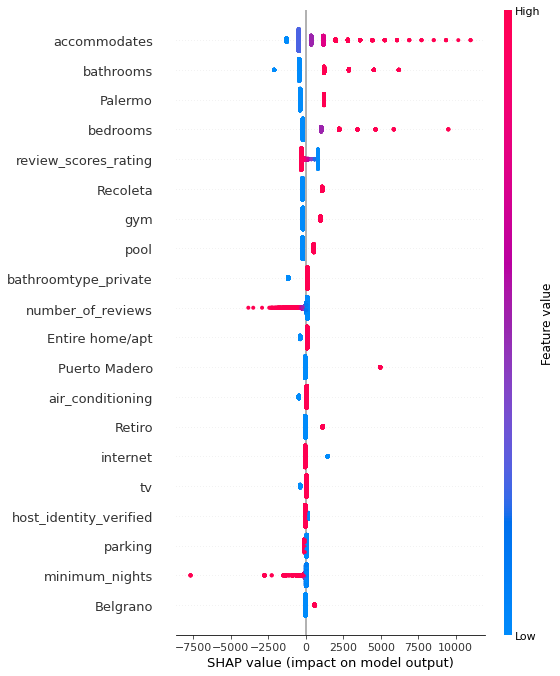

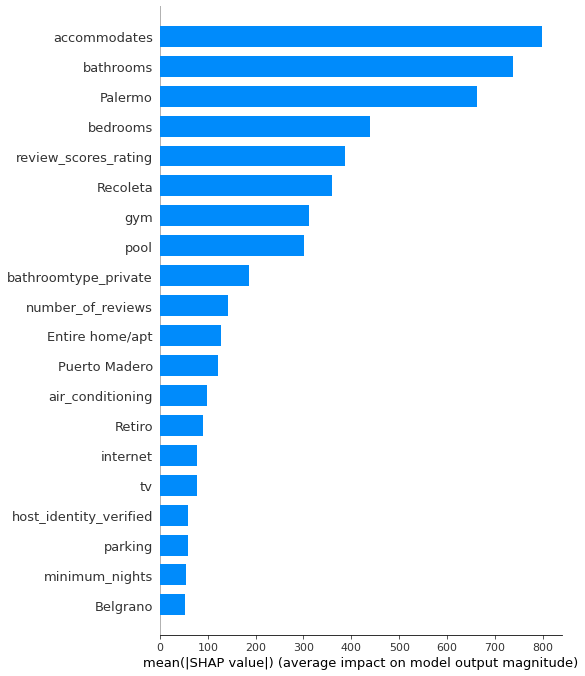

In [19]:
explainer = shap.LinearExplainer(linear_model.Lasso(alpha=models[2]["model"].steps[1][1].alpha,max_iter=models[2]["model"].steps[1][1].max_iter,random_state=models[2]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos XGBoost

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


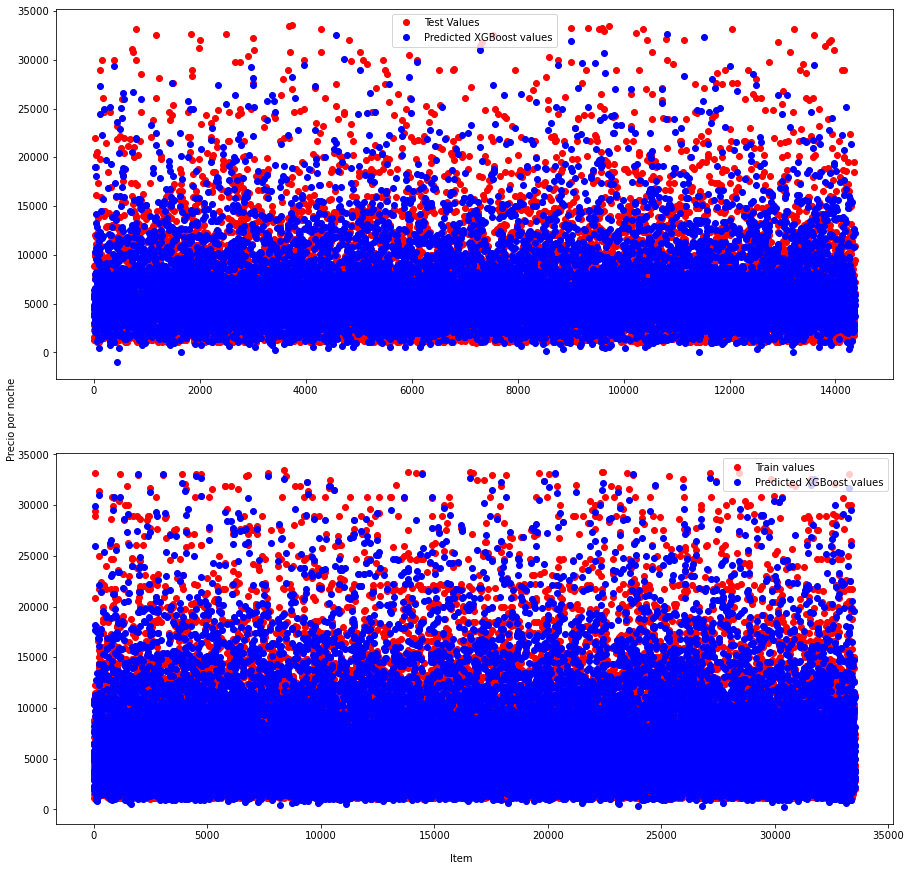

In [20]:
#XGBoost
y_test_prediction = models[3]["model"].predict(X_test)
y_train_prediction = models[3]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[3]["name"])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


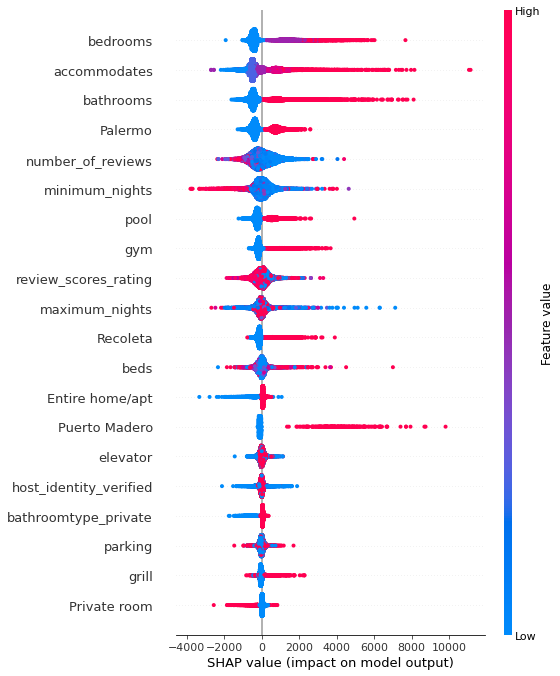

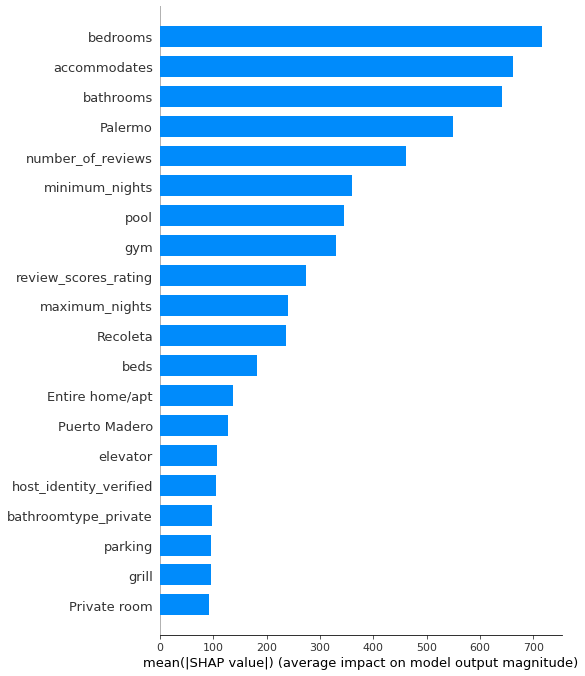

In [21]:
explainer = shap.TreeExplainer(models[3]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos LGBoost

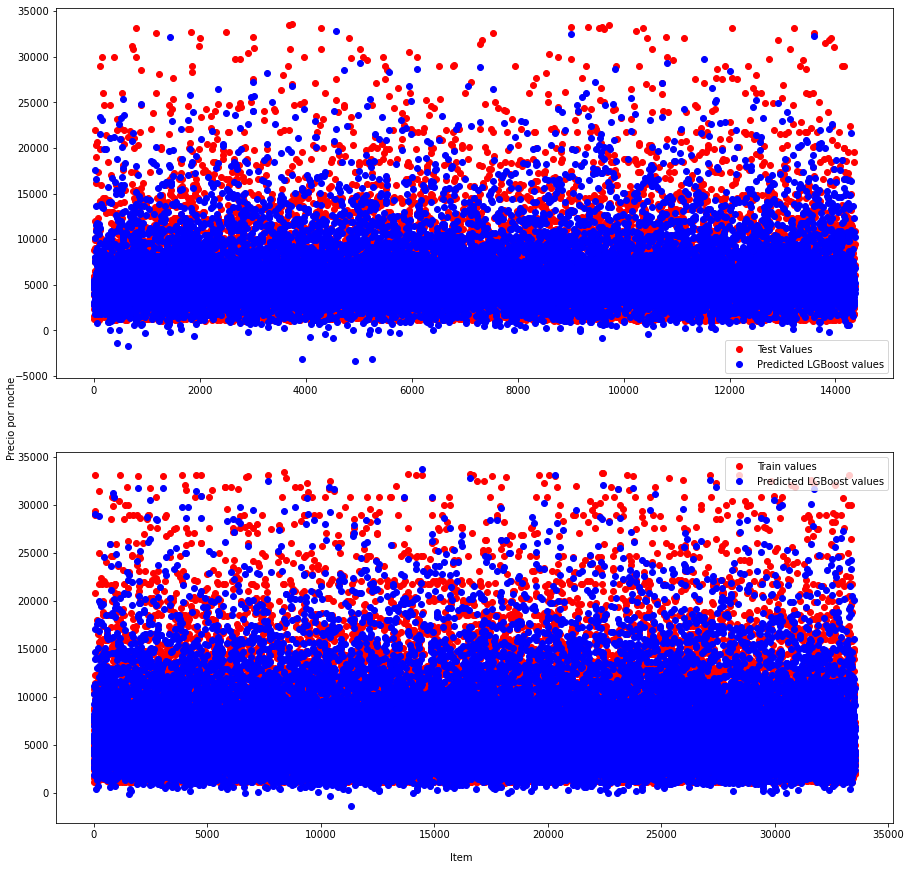

In [22]:
#LGBoost
y_test_prediction = models[4]["model"].predict(X_test)
y_train_prediction = models[4]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[4]["name"])

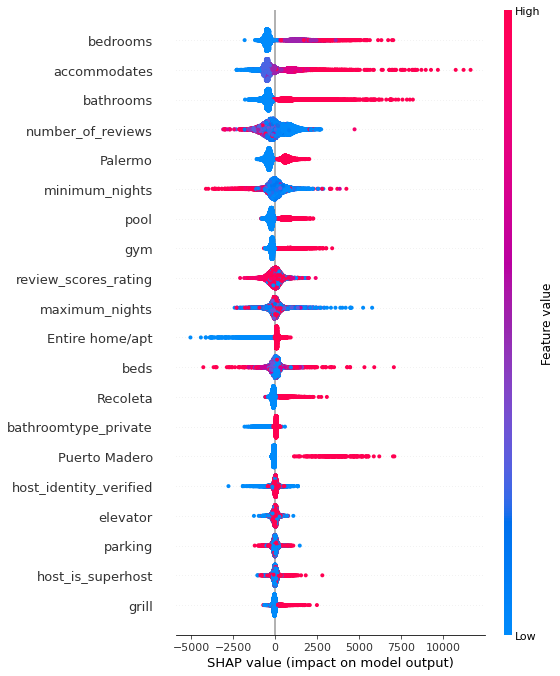

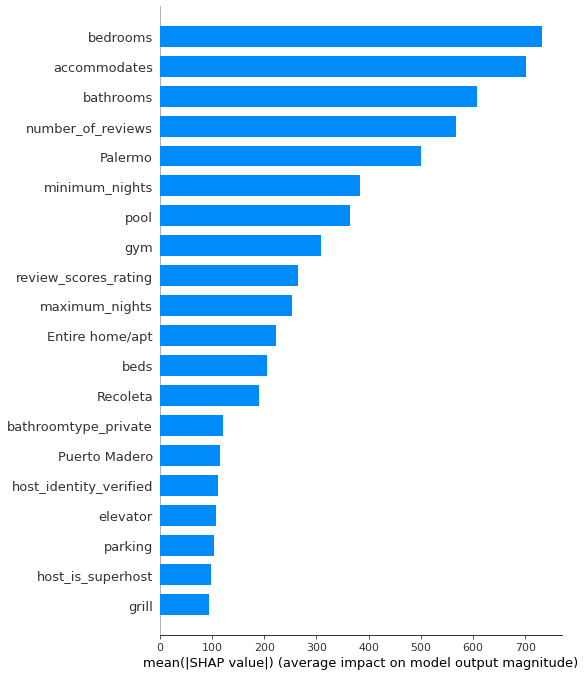

In [23]:
explainer = shap.TreeExplainer(models[4]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos CatBoost

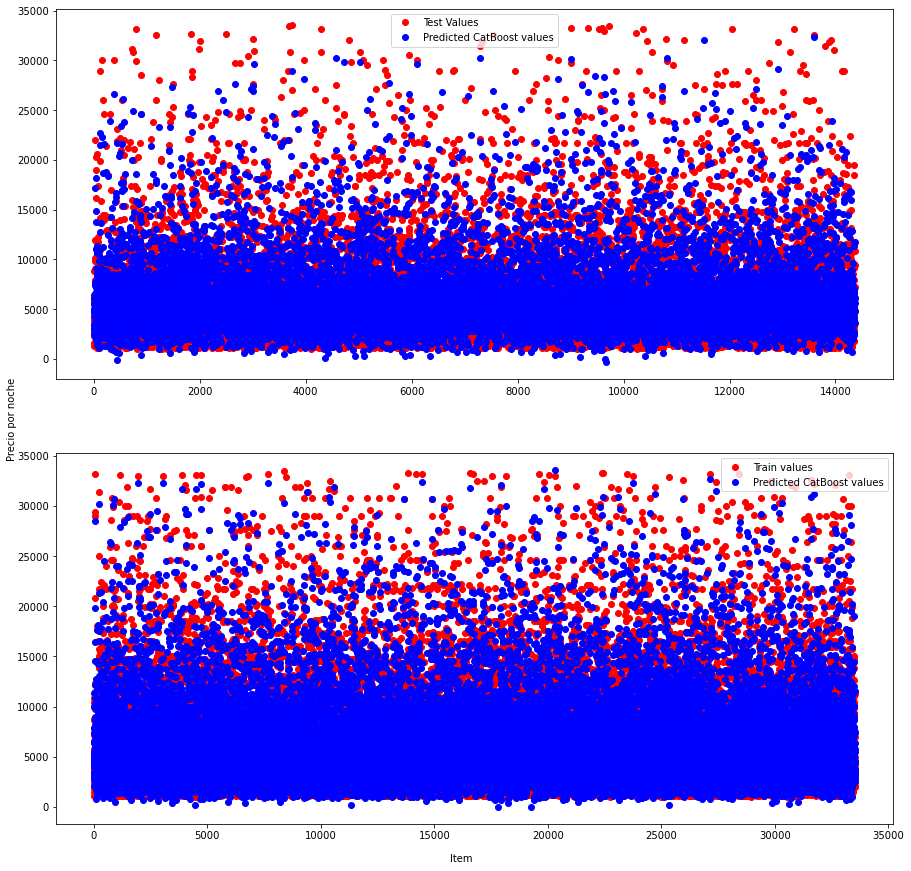

In [24]:
#LGBoost
y_test_prediction = models[5]["model"].predict(X_test)
y_train_prediction = models[5]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[5]["name"])

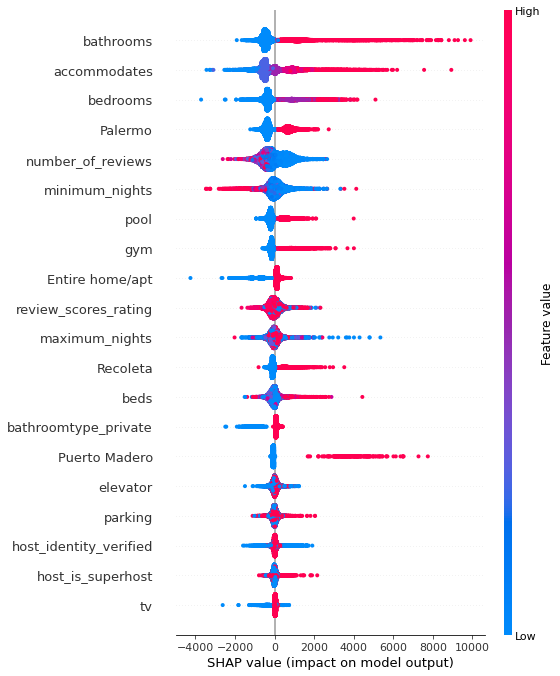

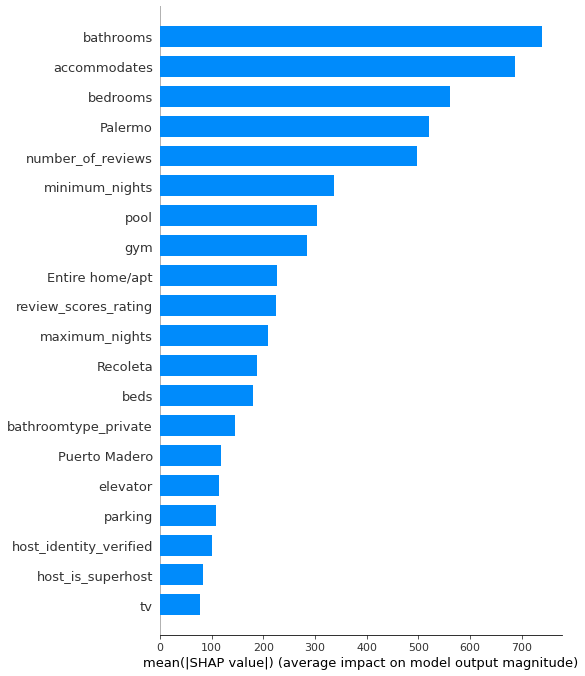

In [25]:
explainer = shap.TreeExplainer(models[5]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Random Forest

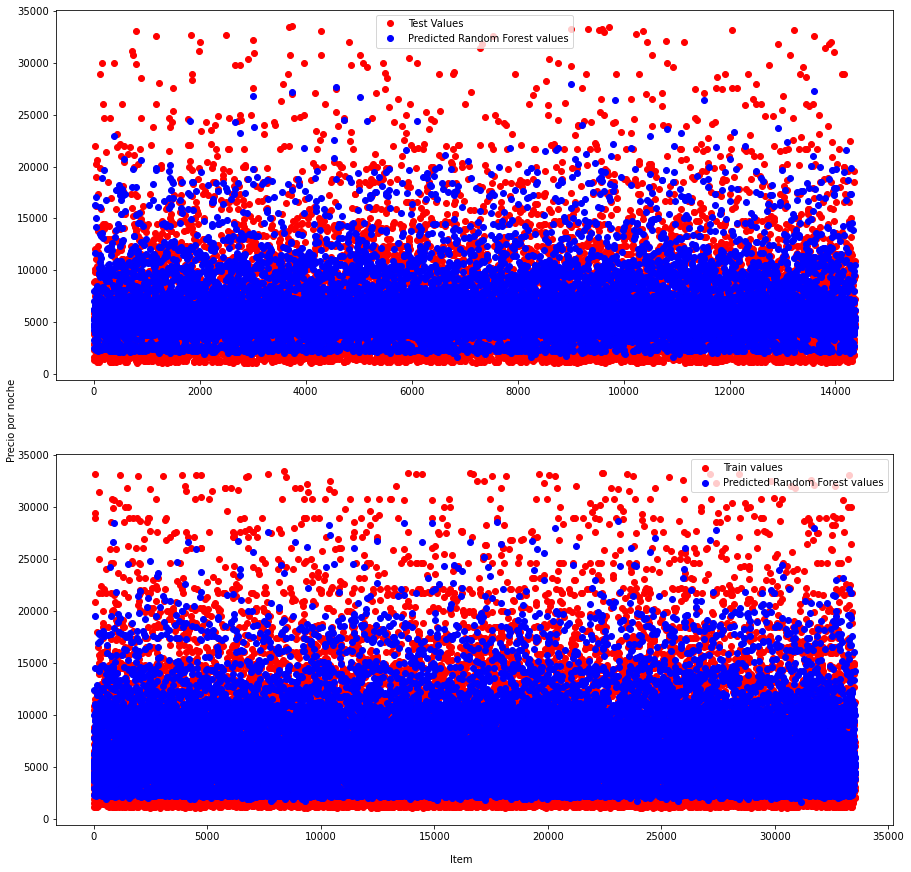

In [26]:
y_test_prediction = models[6]["model"].predict(X_test)
y_train_prediction = models[6]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[6]["name"])

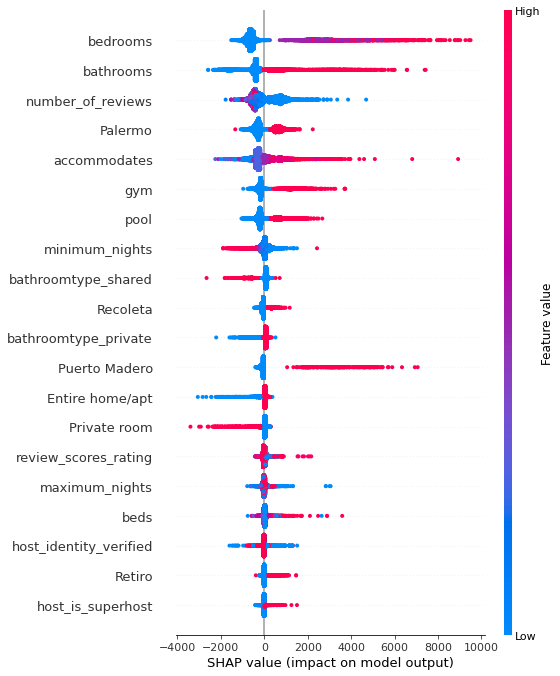

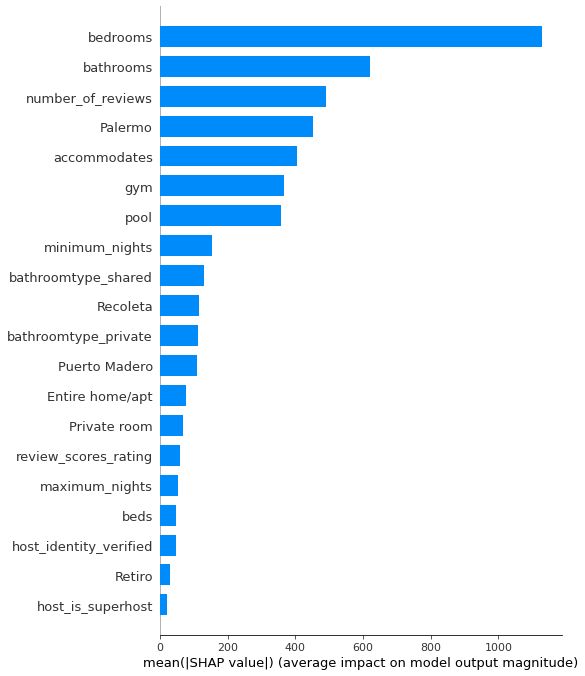

In [27]:
explainer = shap.TreeExplainer(models[6]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

## Modelo

In [28]:
joblib.dump(models[3]["model"],'model2.sav')

['model2.sav']

In [29]:
mod_job = joblib.load("model2.sav")

In [30]:
mod_job.predict(X_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


array([ 3765.2695,  4514.9995,  3057.2698, ...,  5888.032 ,  4831.039 ,
       12279.508 ], dtype=float32)

In [31]:
pd.read_pickle("datatemplate.pkl")

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
1,1.00000,1,2,1,1,1,5687,2,730,24,...,0,0,0,1,0,1,0,0,1,0
